In [ ]:
!pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchaudio==2.0.2+cu118 -f https://download.pytorch.org/whl/torch_stable.html
!pip install mamba-ssm==1.2.0.post1

In [ ]:
import torch
import time
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel
from transformers import AutoTokenizer
import torch.nn as nn

class MambaTextClassifier:
    def __init__(self, model_path, device=None):
        """
        Initialize the classifier with model and tokenizer.

        Args:
            model_path (str): Path to the saved model weights
            device (torch.device, optional): Device to run the model on
        """
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b")
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        # Initialize model
        self.model = MambaLMHeadModel.from_pretrained("state-spaces/mamba-370m")
        self.model.lm_head = nn.Linear(self.model.config.d_model, 2)

        # Load saved weights
        state_dict = torch.load(model_path, map_location=self.device)
        if 'state_dict' in state_dict:
            state_dict = state_dict['state_dict']

        self.model.load_state_dict(state_dict)
        self.model.to(self.device)
        self.model.eval()

        # Define labels
        self.labels = ['Human-written', 'AI-generated']

    def classify_text(self, text):
        """
        Classify a single text input.

        Args:
            text (str): Input text to classify

        Returns:
            dict: Dictionary containing classification results and metadata
        """
        start_time = time.time()

        # Tokenize and prepare input
        encoded_input = self.tokenizer(
            text,
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).to(self.device)

        # Get prediction
        with torch.no_grad():
            outputs = self.model(encoded_input["input_ids"])
            logits = outputs.logits[:, -1, :]  # Use last token logits
            probabilities = torch.softmax(logits, dim=1)

        end_time = time.time()
        computation_time = end_time - start_time

        # Convert probabilities to percentages
        probabilities = probabilities.cpu().numpy().flatten() * 100

        # Format results
        results = {
            'classification': {
                self.labels[i]: f"{probabilities[i]:.2f}%" for i in range(len(self.labels))
            },
            'predicted_class': self.labels[probabilities.argmax()],
            'computation_time': f"{computation_time:.4f} seconds"
        }

        return results

    def print_results(self, results):
        """
        Print formatted classification results.

        Args:
            results (dict): Results dictionary from classify_text
        """
        print(f"\nComputation Time: {results['computation_time']}")
        print("\nPrediction Probabilities:")
        for label, probability in results['classification'].items():
            print(f"{label}: {probability}")
        print(f"\nPredicted Class: {results['predicted_class']}")


In [ ]:
classifier = MambaTextClassifier("drive/MyDrive/mamba_model/mamba_ai_essay_detection_model_balanced.pth")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Computation Time: 30.6316 seconds

Prediction Probabilities:
Human-written: 0.96%
AI-generated: 99.04%

Predicted Class: AI-generated


In [ ]:
text = """
Nearly ten years had passed since the Dursleys had woken up to find their nephew on the front step, but Privet Drive had hardly changed at all. The sun rose on the same tidy front gardens and lit up the brass number four on the Dursleys' front door; it crept into their living room, which was almost exactly the same as it had been on the night when Mr. Dursley had seen that fateful news report about the owls. Only the photographs on the mantelpiece really showed how much time had passed. Ten years ago, there had been lots of pictures of what looked like a large pink beach ball wearing different-colored bonnets - but Dudley Dursley was no longer a baby, and now the photographs showed a large blond boy riding his first bicycle, on a carousel at the fair, playing a computer game with his father, being hugged and kissed by his mother. The room held no sign at all that another boy lived in the house, too.

Yet Harry Potter was still there, asleep at the moment, but not for long. His Aunt Petunia was awake and it was her shrill voice that made the first noise of the day.

"Up! Get up! Now!"

Harry woke with a start. His aunt rapped on the door again.

"Up!" she screeched. Harry heard her walking toward the kitchen and then the sound of the frying pan being put on the stove. He rolled onto his back and tried to remember the dream he had been having. It had been a good one. There had been a flying motorcycle in it. He had a funny feeling he'd had the same dream before.

His aunt was back outside the door.

"Are you up yet?" she demanded.

"Nearly," said Harry.

"Well, get a move on, I want you to look after the bacon. And don't you dare let it burn, I want everything perfect on Duddy's birthday."

Harry groaned.

"What did you say?" his aunt snapped through the door.

"Nothing, nothing . . ."

Dudley's birthday - how could he have forgotten? Harry got slowly out of bed and started looking for socks. He found a pair under his bed and, after pulling a spider off one of them, put them on. Harry was used to spiders, because the cupboard under the stairs was full of them, and that was where he slept.

When he was dressed he went down the hall into the kitchen. The table was almost hidden beneath all Dudley's birthday presents. It looked as though Dudley had gotten the new computer he wanted, not to mention the second television and the racing bike. Exactly why Dudley wanted a racing bike was a mystery to Harry, as Dudley was very fat and hated exercise - unless of course it involved punching somebody. Dudley's favorite punching bag was Harry, but he couldn't often catch him. Harry didn't look it, but he was very fast.

Perhaps it had something to do with living in a dark cupboard, but Harry had always been small and skinny for his age. He looked even smaller and skinnier than he really was because all he had to wear were old clothes of Dudley's, and Dudley was about four times bigger than he was. Harry had a thin face, knobbly knees, black hair, and bright green eyes. He wore round glasses held together with a lot of Scotch tape because of all the times Dudley had punched him on the nose. The only thing Harry liked about his own appearance was a very thin scar on his forehead that was shaped like a bolt of lightning. He had had it as long as he could remember, and the first question he could ever remember asking his Aunt Petunia was how he had gotten it.

"In the car crash when your parents died," she had said. "And don't ask questions."

Don't ask questions - that was the first rule for a quiet life with the Dursleys.

Uncle Vernon entered the kitchen as Harry was turning over the bacon.

"Comb your hair!" he barked, by way of a morning greeting.
"""
results = classifier.classify_text(text)

classifier.print_results(results)


Computation Time: 0.0711 seconds

Prediction Probabilities:
Human-written: 99.52%
AI-generated: 0.48%

Predicted Class: Human-written


In [ ]:
import pandas as pd
import torch
import time
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

######################
# Setup Transformer Model
######################
transformer_model = AutoModelForSequenceClassification.from_pretrained("hanzla/bert-essay-classifier")
transformer_tokenizer = AutoTokenizer.from_pretrained("hanzla/bert-essay-classifier")
transformer_model.eval()

def classify_text_transformer(text):
    start_time = time.time()
    inputs = transformer_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = transformer_model(**inputs)
        end_time = time.time()
    return end_time - start_time

######################
# Setup MAMBA Model
######################
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel

class MambaTextClassifier:
    def __init__(self, model_path, device=None):
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b")
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        self.model = MambaLMHeadModel.from_pretrained("state-spaces/mamba-370m")
        self.model.lm_head = nn.Linear(self.model.config.d_model, 2)
        state_dict = torch.load(model_path, map_location=self.device)
        if 'state_dict' in state_dict:
            state_dict = state_dict['state_dict']
        self.model.load_state_dict(state_dict)
        self.model.to(self.device)
        self.model.eval()

    def classify_text(self, text):
        start_time = time.time()
        encoded_input = self.tokenizer(
            text,
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).to(self.device)
        with torch.no_grad():
            _ = self.model(encoded_input["input_ids"])  # We don't need the output right now, just timing
            end_time = time.time()
        return end_time - start_time

mamba_classifier = MambaTextClassifier("drive/MyDrive/mamba_model/mamba_ai_essay_detection_model_balanced.pth")

######################
# Load the dataset from CSV
######################
df = pd.read_csv("sampled_dataset_3.csv")

######################
# Data Collection with tqdm
######################
transformer_times = []
mamba_times = []
df['transformer_time'] = 0.0
df['mamba_time'] = 0.0

# Using tqdm to create a progress bar
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing samples"):
    text = row['text']
    # Measure transformer model time
    t_time = classify_text_transformer(text)
    # Measure MAMBA model time
    m_time = mamba_classifier.classify_text(text)
    df.at[idx, 'transformer_time'] = t_time
    df.at[idx, 'mamba_time'] = m_time

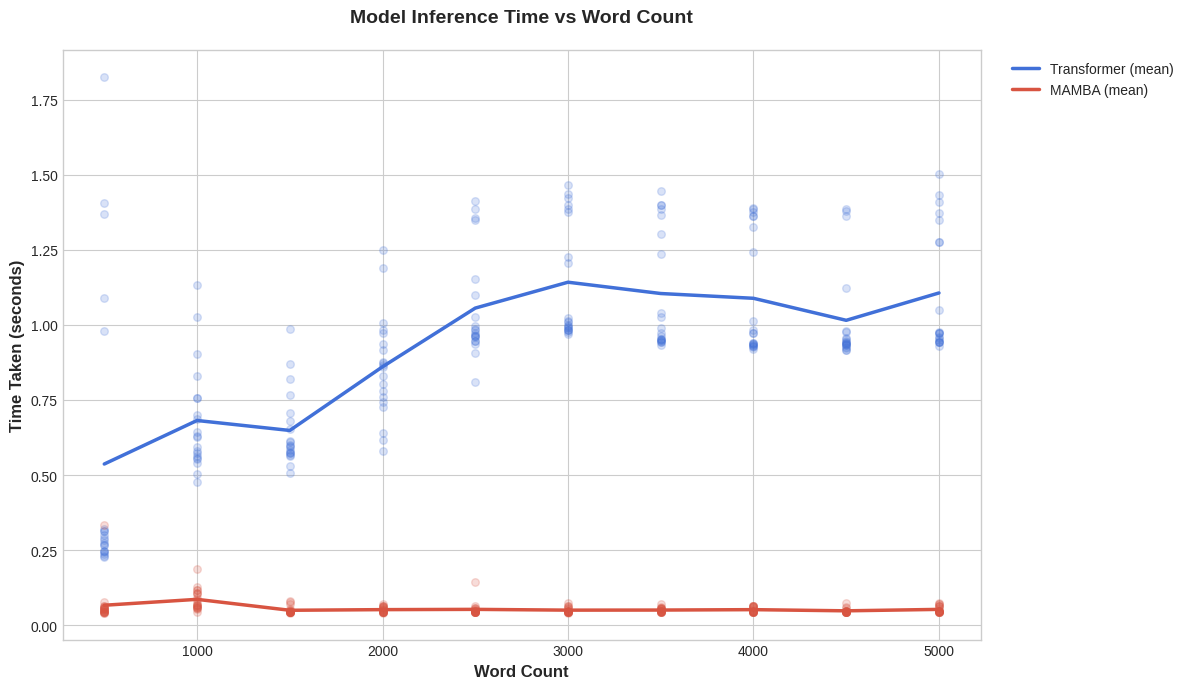

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Create the figure with a specific size and DPI
plt.figure(figsize=(12, 7), dpi=100)

# Calculate mean values for each word count
df_means = df_sorted.groupby('word_count').agg({
    'transformer_time': 'mean',
    'mamba_time': 'mean'
}).reset_index()

# Plot mean lines
plt.plot(df_means['word_count'], df_means['transformer_time'],
         color='#4170d8', label='Transformer (mean)',
         linewidth=2.5, zorder=3)
plt.plot(df_means['word_count'], df_means['mamba_time'],
         color='#d85441', label='MAMBA (mean)',
         linewidth=2.5, zorder=3)

# Add scatter points with transparency
plt.scatter(df_sorted['word_count'], df_sorted['transformer_time'],
           color='#4170d8', alpha=0.2, s=30, zorder=2)
plt.scatter(df_sorted['word_count'], df_sorted['mamba_time'],
           color='#d85441', alpha=0.2, s=30, zorder=2)

# Customize the plot
plt.xlabel("Word Count", fontsize=12, fontweight='bold')
plt.ylabel("Time Taken (seconds)", fontsize=12, fontweight='bold')
plt.title("Model Inference Time vs Word Count", fontsize=14, fontweight='bold', pad=20)

# Customize ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Customize legend
plt.legend(fontsize=10, framealpha=1,
          bbox_to_anchor=(1.02, 1),
          loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()